# **Project: Jewellery Information Retrieval, Topic Modelling, and Summarisation Tool**

### Aims
This project aims to implement an information retrieval, topic modelling and a summarisation tool.


### Task Descriptions: Information Retrieval, Topic Modelling, and Summarisation

1. **Pre-process the dataset**. 
2. **Latent Semantic Indexing (LSI)**. Use the pre-processed dataset for the remaining tasks.
    * Develop a Latent Semantic Indexing (LSI) model. Develop functionality such that for each query, the LSI model retrieves the top 10 most similar reviews from the dataset. 

    * Empirically tune the LSI model (weighting scheme and SVD dimensions) and present the results. Show the results of the best tuned models in a single graph. 
    
3. **Neural information retrieval**.
    * Develop a neural information retrieval model and compare its performance to the best-tuned LSI model from Task 3. 
    * Develop an interactive interface that will allow the user to type in their own query and to interact with the results.

4. **Topic modelling and visualisation of search results**.
    * Extend Task 3 to include topic modelling functionality. For this, implement and tune a topic model (e.g. Latent Dirichlet Allocation (LDA), Gensim, BERTopic) that, takes the top n search results and clusters them into topics (n can be user-defined or set to 50). Evaluate the performance of the model using suitable evaluation metrics. For each query, you will have the topics of its top n results.
    * Add functionality that will enable the user to interactively visualise the topics and keywords.


5. **Summarisation of search results**.
    * Extend Task 3 to include an approach (either neural or non-neural) that takes the top 10 search results and summarises them. Evaluate the performance of the model using suitable evaluation metrics and the target summaries. 
    * Add extra functionality to enable the user to choose which results to summarise.


## Load Data

In [1]:
# Mount drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# set datasets
data_path = "/content/drive/My Drive/Colab Notebooks/Datasets/"
!ls "/content/drive/My Drive/Colab Notebooks/Datasets/"

JewelleryReviewsLSA.csv  JewelleryReviewsQueryRelevantID.csv


## Data Exploration

In [3]:
# import necessary libraries
from numpy import array
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from pandas import DataFrame
from matplotlib import pyplot
import random
import nltk
import numpy
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import rand
from sklearn.metrics.pairwise import cosine_similarity
from numpy import argsort
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import Counter


# load data
file1 = "/content/drive/My Drive/Colab Notebooks/Datasets/JewelleryReviewsLSA.csv"
df = pd.read_csv(file1)
df['Reviews'].head()

0    i expect like regular size of ring,but this on...
1    I ordered a ring that stated Toe Ring" in the ...
2    This ring is a beautiful ring but the first sh...
3    This ring is a beautiful ring but the first sh...
4    This is a huge waste of money I had it for abo...
Name: Reviews, dtype: object

In [4]:
print(f"Number of reviews: {len(df['Reviews'])}")

Number of reviews: 200


In [5]:
file2 = "/content/drive/My Drive/Colab Notebooks/Datasets/JewelleryReviewsQueryRelevantID.csv"
JewelleryReviewsQueryRelevantID_df = pd.read_csv(file2)
JewelleryReviewsQueryRelevantID_df.head()

,Query1,Query2,Query3,Query4,Query5,Query6,Query7,Query8,Unnamed: 8,Query1Text,Query2Text,Query3Text,Query4Text,Query5Text,Query6Text,Query7Text,Query8Text
0,36164,57123.0,33251.0,40373.0,13373.0,45860.0,209.0,642.0,NaN,The ring is a great gift. My friend loves it,horrible bad quality bracelet,arrived promptly and happy with the seller,wear it with casual wear,i expected better quality. i will return this ...,looks beautiful. The design is pretty. pefect ...,This ring looks nothing like the picture. the ...,braclet looked just like its picture and is ni...
1,58481,25299.0,17304.0,28648.0,17607.0,46500.0,28542.0,10642.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,26246,55017.0,50019.0,37486.0,41459.0,27474.0,216.0,37794.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2033,7432.0,27679.0,30640.0,54748.0,43945.0,47345.0,45518.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,48779,2114.0,6158.0,2131.0,33571.0,52837.0,11356.0,3494.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Task 1: Preprocess the dataset

### **Defining Functions to Process Data**

In [6]:
nltk.download('stopwords')

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
    # load doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # update counts
    vocab.update(tokens)
 
 # load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# save list to file
def save_list(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# split train and test
def random_sample(num1, num2):
    dataList = list(range(num1))                           
    TrainIndex = []                                        
    for i in range(num2):                                 
        randIndex = int(random.uniform(0,len(dataList))) 
        TrainIndex.append(dataList[randIndex])            
        del(dataList[randIndex])                         
    TestIndex = dataList                              
    return TrainIndex,TestIndex  

# load doc into memory
def load_doc_lines(filename):
    file = open(filename,'rt')
    lines = list()
  # read all text as lines
    while 1:
        line = file.readline()   
        if not line:    
            break
        pass
        lines.append(line.strip("\n"))  
    # close the file
    file.close()
    return lines


    # turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
 
    # convert to lower case
    tokens = [word.lower() for word in tokens]

    # stemming of words
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]

    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load doc, clean and return line of tokens
def doc_to_line(doc):
    # load the doc
    # doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    # tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(files):
    lines = list()
    # walk through all files in the folder
    for doc in files:
        # print(len(doc))
        line = doc_to_line(doc)
        # add to list
        lines.append(line)
    return lines

# prepare words encoding of docs
def prepare_data(train_docs, mode, vocab):
    # encode training data set
    vectorizer = CountVectorizer(vocabulary=vocab)
    transformer = TfidfTransformer(norm='l2')
    Xtrain = transformer.fit_transform(vectorizer.fit_transform(train_docs))
    return Xtrain

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Task 2: Latent Semantic Indexing (LSI)

In [8]:
# load the dataset 
reviews = df['Reviews'].tolist() 

train_docs = process_docs(reviews)

# generate vocabulary
vocab = []
for ll in train_docs:
    tt = ll.split()
    for ww in tt:
        if ww not in vocab:
            vocab.append(ww)


# Prepare the training data
Xtrain = prepare_data(train_docs, 'tfidf', vocab)

# Initialize the TruncatedSVD model with 50 components
trunc_SVD_model = TruncatedSVD(n_components=50)

# Fit the model to the training data and transform it
approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)

# Print the shape of the approximated training data
print("Approximated Xtrain shape: " + str(approx_Xtrain.shape))

Approximated Xtrain shape: (200, 50)


### **2a Information Retrieval using Unoptimized Model**


In [9]:
# Create a list to store the queries
queries = []

# Get queries from dataset 
for x in range(9,17):
    query = JewelleryReviewsQueryRelevantID_df.iat[0, x]
    queries.append(query)


# store relevant IDs for each query
Query1 = [36164, 58481, 26246, 2033, 48779, 34523, 9726, 56494, 49525, 45278, 35694, 41876, 17309, 11135, 17273, 11247]
Query2 = [57123, 25299, 55017, 7432, 2114, 40871]
Query3 = [33251, 17304, 50019, 27679, 6158, 22408, 29722, 36677, 2780, 17944, 19944, 31657, 52867, 49216]
Query4 = [40373, 28648, 37486, 30640, 2131, 19852, 2134, 36585, 26535, 51474, 21070, 56330, 53660, 44126]
Query5 = [13373, 17607, 41459, 54748, 33571]
Query6 = [45860, 46500, 27474, 43945, 52837, 12358, 41319, 39932, 45146, 50197, 8341, 52375]
Query7 = [209, 28542, 216, 47345, 11356, 33632, 38637, 7110, 6649, 51356, 44358, 36165, 943, 37864]
Query8 = [642, 10642, 37794, 45518, 3494, 735, 10037, 41872, 28542, 53409, 56865, 44489, 44490]

re_ID = [Query1, Query2, Query3, Query4, Query5, Query6, Query7, Query8]


# preprocess query
def preprocess_query(review, mode, vocab):
    # clean
    tokens = clean_doc(review)
    # convert to line
    line = ' '.join(tokens)
    # encode
    vectorizer = CountVectorizer(vocabulary=vocab)
    transformer = TfidfTransformer(norm='l2')
    encoded = transformer.fit_transform(vectorizer.fit_transform([line]))
    return encoded

### **Loop through queries and retrieve the top 10 most similar reviews**

In [10]:
# loop queries
j = 0
for query in queries:
    # retrieval
    encoded_query = preprocess_query(query, 'tfidf', vocab)
    transformed_query = trunc_SVD_model.transform(encoded_query)
    similarities = cosine_similarity(approx_Xtrain, transformed_query)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]

    # get review IDs for the index  
    IDs = df['ID'].iloc[indexes]

    # convert review IDs dataframe to list
    ID_list = IDs.tolist()
  
    # print top 10 similar reviews for each query in queries
    print('\n' + 'Query%d: '%(j+1) + query)
    for i in range(10):
        print("Top " + str(i+1) + ' result: ID%d '%(indexes[i]+1), reviews[indexes[i]])
  
    j += 1


Query1: The ring is a great gift. My friend loves it
Top 1 result: ID115  I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.
Top 2 result: ID113  I love this ring fits just right and I showed my daughter the ring and she loved it as well. Great for everyday wear and the price was great..
Top 3 result: ID105  my wife loves the ring, it was a great gift. extremelly cheap and high quality.
Top 4 result: ID118  My mother loved this and was a great birthday gift. These look even better in person and go great with anything.
Top 5 result: ID111  I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring
Top 6 result: ID107  I love my birthstone and I wanted a piece of jewelry that symbolized the simple purity of the Blue Topaz. This ring did that for me. As a gift to myself for my birthday this year, it was definitely a great gift and a welcomed addition to my collection.
Top 7 result: ID109  This ring 

### **Task 2b: Empirically tuning the LSI model** 
This section presents the 2 best performing models based on our defined metrics, after carrying out a series of experiments with a range of model parameters.

To conduct our investigation to optimize the performance of our initial model, a combination of the following paramers were experimented with:

**Weighting schemes:[Binary, TF-IDF, BM25]**

**SVD dimensions:[25,50,100,150,200,250,300]**

##### **Methodology**

The methodolgy used to experiment with the above parameters was as follows:

1) We first determined the optimal weighting scheme by keeping the number of SVD dimensions constant (50) and used the average precision and recall score to evaluate the model's performance using each weighting scheme. 

2) Having selected the best weighting scheme, we then varied the number of SVD dimensions to further optimze the LSI model.

### **Defining metric functions to evaluate models**

In [11]:
# Interplot Precision for standard Recall
def InterplotPrecision(p=0.1, Precision=None, Recall=None):

    if p >= 1.0:
        p = 0.9

    Mark = np.zeros(2)
    l = 0
    r = 0
    for i in range(len(Recall)):
        if Recall[i] >= p and Mark[0] == 0:
            l = i
            Mark[0] = 1
        if Recall[i] >= p + 0.1 and Mark[1] == 0:
        # if Recall[i] >= 1.0 and Mark[1] == 0:
            r = i
            Mark[1] = 1
    y = max(Precision[l:(r+1)])
    return y

# obtain y axis for R/P curve
def compute_RP_yaxis(Precision=None, Recall=None):
    y_axis = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
    for i in range(11):
        pInput = 0.1 * i
        y_axis[i] = InterplotPrecision(p=pInput, Precision=Precision, Recall=Recall)
    return y_axis

# compute Recall, Precision, F1-measure
def compute_R_P_F1(re_mark=None, QuRe_ID =None):
    Recall = []
    Precision = []
    F1measure = []
    for i in range(len(re_mark)):
        r = sum(re_mark[:(i+1)])
        Re = r/(len(QuRe_ID))
        Pr = r/(i+1)   
        # avoid divisor to be 0
        FD = Re + Pr 
        if FD == 0:
            FD=1
        F1 = 2*Re*Pr/FD

        Recall.append(Re)
        Precision.append(Pr)
        F1measure.append(F1)
    return Recall, Precision, F1measure

### **Results of the 2 best models**

Approximated Xtrain shape: (200, 50)
Approximated Xtrain shape: (200, 25)


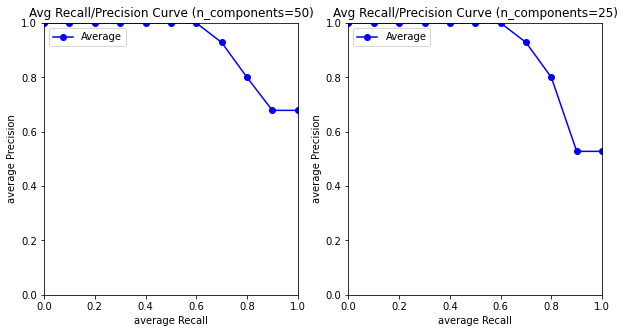

,Model,Average Recall@1~10:,Average Precision@1~10,Average F1measure@1~10
0,Model 1,"[0.11, 0.23, 0.34, 0.46, 0.57, 0.69, 0.72, 0.7...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.88, 0.8...","[0.2, 0.36, 0.49, 0.6, 0.69, 0.77, 0.77, 0.76,..."
1,Model 2,"[0.11, 0.23, 0.34, 0.46, 0.57, 0.69, 0.72, 0.7...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.93, 0.88, 0.8...","[0.2, 0.36, 0.49, 0.6, 0.69, 0.77, 0.77, 0.76,..."


In [21]:
import matplotlib.pyplot as plt

# ---------------------------- Best model ------------------------------- #
trunc_SVD_model = TruncatedSVD(n_components=50)
approx_Xtrain = trunc_SVD_model.fit_transform(Xtrain)
print("Approximated Xtrain shape: " + str(approx_Xtrain.shape))

AllRecall = []
AllPrecision = []
AllF1measure = []
# loop queries
j = 0
for query in queries:
    # retrieval
    encoded_query = preprocess_query(query, 'tfidf', vocab)
    transformed_query = trunc_SVD_model.transform(encoded_query)
    similarities = cosine_similarity(approx_Xtrain, transformed_query)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]
    
    IDs = df['ID'].iloc[indexes]

    ID_list = IDs.tolist()

    # Mark the relevant index
    re_mark = []
    for i in range(len(ID_list)):
        if (ID_list[i]) in re_ID[j]:
            re_mark.append(1)
        else:
            re_mark.append(0)
    # print(re_mark)

    # compute Recall, Precision, F1-measure
    Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=re_ID[j])
  
    Recall = np.array(Recall)
    Precision = np.array(Precision)
    F1measure = np.array(F1measure)

    # save
    AllRecall.append(Recall)
    AllPrecision.append(Precision)
    AllF1measure.append(F1measure)

    j += 1

# compute average Recall, average Precision, average F1-measure
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)
AveRecall = (AllRecall[0] + AllRecall[1])/2
AvePrecision = (AllPrecision[0] + AllPrecision[1])/2
AveF1measure = (AllF1measure[0] + AllF1measure[1])/2

"""

print("\nAverage Recall, average Precision, average F1-measure: ")
print("average Recall@1~10: ", np.around(AveRecall[:10],2))
print("average Precision@1~10: ", np.around(AvePrecision[:10],2))
print("average F1measure@1~10: ", np.around(AveF1measure[:10],2))
"""

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# plot 1 average R/P curve
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)
ax1.plot(x_axis, y_axis, '-o', color="blue", label="Average")
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xlabel('average Recall')
ax1.set_ylabel('average Precision')
ax1.set_title('Avg Recall/Precision Curve (n_components=50)')
ax1.legend()







# ---------------------------- Second best model ------------------------------- #

trunc_SVD_model2 = TruncatedSVD(n_components=25)
approx_Xtrain2 = trunc_SVD_model2.fit_transform(Xtrain)
print("Approximated Xtrain shape: " + str(approx_Xtrain2.shape))

AllRecall2 = []
AllPrecision2 = []
AllF1measure2 = []

# loop queries
j = 0
for query in queries:
    # retrieval
    encoded_query = preprocess_query(query, 'tfidf', vocab)
    transformed_query = trunc_SVD_model2.transform(encoded_query)
    similarities = cosine_similarity(approx_Xtrain2, transformed_query)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]

    IDs = df['ID'].iloc[indexes]

    ID_list = IDs.tolist()

    # Mark the relevant index
    re_mark = []
    for i in range(len(ID_list)):
        if (ID_list[i]) in re_ID[j]:
            re_mark.append(1)
        else:
            re_mark.append(0)
    # print(re_mark)

    # compute Recall, Precision, F1-measure
    Recall2, Precision2, F1measure2 = compute_R_P_F1(re_mark=re_mark, QuRe_ID=re_ID[j])
    
    Recall2 = np.array(Recall2)
    Precision2 = np.array(Precision2)
    F1measure2 = np.array(F1measure2)

    # save
    AllRecall2.append(Recall2)
    AllPrecision2.append(Precision2)
    AllF1measure2.append(F1measure2)

    j += 1

# compute average Recall2, average Precision2, average F1-measure2
AllRecall2 = np.array(AllRecall2)
AllPrecision2 = np.array(AllPrecision2)
AllF1measure2 = np.array(AllF1measure2)
AveRecall2 = (AllRecall2[0] + AllRecall2[1])/2
AvePrecision2 = (AllPrecision2[0] + AllPrecision2[1])/2
AveF1measure2 = (AllF1measure2[0] + AllF1measure2[1])/2

"""
print("\nAverage Recall2, average Precision2, average F1-measure2: ")
print("average Recall2@1~10: ", np.around(AveRecall2[:10],2))
print("average Precision2@1~10: ", np.around(AvePrecision2[:10],2))
print("average F1measure2@1~10: ", np.around(AveF1measure2[:10],2))
"""

# plot 2 average R/P curve
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=AvePrecision2, Recall=AveRecall2)
ax2.plot(x_axis, y_axis, '-o', color="blue", label="Average")
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xlabel('average Recall')
ax2.set_ylabel('average Precision')
ax2.set_title('Avg Recall/Precision Curve (n_components=25)')
ax2.legend()


# Display the figure
plt.show()

# Define the data
data = {'Model': ['Model 1', 'Model 2'],
        'Average Recall@1~10:': [np.around(AveRecall[:10],2), np.around(AveRecall2[:10],2)],
        'Average Precision@1~10': [ np.around(AvePrecision[:10],2), np.around(AvePrecision2[:10],2)],
        'Average F1measure@1~10': [np.around(AveF1measure[:10],2), np.around(AveF1measure2[:10],2)],
        }

# Create a DataFrame from the data
score_df = pd.DataFrame(data)

# Display the DataFrame
score_df.head()

### **Remarks**

The best weighting scheme for our model was found to be the TF-IDF weighting scheme. The 2 best performing models shown above consisted of 50 and 25 SVD dimensions respectivley.

As we can see both models have excellent precision scores for relativley low recall scores. However, as we would expect, the precsion starts to decrease as the recall score increases above 60%. This is ofcourse due to the lack of specificity. 

In the experiment we noticed as we increased the number of components used for the truncatedSVD model, the performance of the retrieval system started to decrease. A reason for 50 components outperforming 25 components, however, could be due to too much loss of information.

## Task 3: Neural information retrieval


In [61]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### **Load and Prepare dataset**

In [37]:
# Import necessary librairies
from numpy import array
from string import punctuation
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
import random
import nltk
import numpy
import pandas as pd

nltk.download('stopwords')

# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

# turn a doc into clean tokens
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # convert to lower case
    tokens = [word.lower() for word in tokens]
    # remove punctuation from each token
    table = str.maketrans('', '', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens


def load_doc_lines(filename):
    file = open(filename,'rt')
    lines = list()
   # read all text as lines
    while 1:

        line = file.readline()   
        if not line:
            break
        pass
        lines.append(line.strip("\n"))   
    # close the file
    file.close()
    return lines

# load doc, clean and return line of tokens
def doc_to_line(doc):
    # load the doc
    # doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    return ' '.join(tokens)

# load all docs in a directory
def process_docs(files):
    lines = list()
    # walk through all files in the folder
    for doc in files:
        # print(len(doc))
        line = doc_to_line(doc)
        # add to list
        lines.append(line)
    return lines

train_docs = reviews

# process all train reviews
train_docs = process_docs(train_docs)


train_docs = pd.Series(train_docs) 


print(train_docs.shape)


(200,)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


###**Load neural information retrieval model**

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

# Loading the Pre-trained BERT model
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')


# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


###**Embed train set**

In [39]:
N = 200 # N number of train reviews as a group to be embeded
with torch.no_grad():
    # Tokenization
    tokenized = train_docs[0:N].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    # padding
    max_len = 0
    q = 0
    for i in tokenized.values:
        
        # BERT only accept maximum 512 values
        if len(i) > 512:
            temp = tokenized.values[q]
            tokenized.values[q] = temp[:512]
            i = tokenized.values[q]
            print('too much tokenized.values for BERT, only 512 are taken')

        # print(len(i))
        if len(i) > max_len:
            max_len = len(i)
        q += 1

    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    np.array(padded).shape

    # masking
    attention_mask = np.where(padded != 0, 1, 0)
    attention_mask.shape

    # run the model
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    print(input_ids.shape)

    last_hidden_states = model(input_ids, attention_mask=attention_mask)

    train_features = last_hidden_states[0][:,0,:].numpy()

print(len(train_features))  




torch.Size([200, 80])
200


###**Neural Model Evaluation**



Query1: The ring is a great gift. My friend loves it
Top 1 result: ID9  I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.
Top 2 result: ID88  I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.
Top 3 result: ID115  I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.
Top 4 result: ID67  I love the ring and suggest every girl should have this ring in their jewelry collection.
Top 5 result: ID45  What sparkle. It is so pretty and dainty. Just what I was looking for.
Top 6 result: ID105  my wife loves the ring, it was a great gift. extremelly cheap and high quality.
Top 7 result: ID189  It is as nice as it looks on the picture. :) I like it. :)
Top 8 result: ID36  I have been told that the ring is very comfortable to wear and he was quite surprised and please to see the Masonic ring in titanium.
Top 9 result: ID25  This ring was a little to

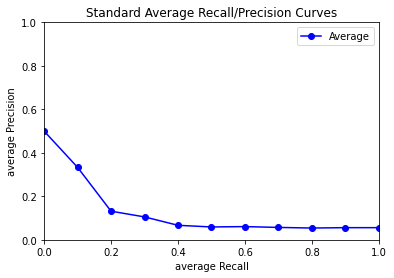

,Model,Average Recall@1~10:,Average Precision@1~10,Average F1measure@1~10
0,Neural model,"[0.08, 0.08, 0.11, 0.11, 0.11, 0.15, 0.15, 0.1...","[0.5, 0.25, 0.33, 0.25, 0.2, 0.25, 0.21, 0.19,...","[0.14, 0.12, 0.16, 0.15, 0.14, 0.17, 0.16, 0.1..."


In [40]:
import numpy as np
import matplotlib.pyplot as plt

def embed_query(query):
    # Tokenize the query
    tokenized = tokenizer.encode(query, add_special_tokens=True)
    # Pad the tokenized query to the maximum length
    max_len = 512 # Set the maximum length to 512 (the maximum number of tokens BERT can process in a single batch)
    padded = tokenized + [0]*(max_len-len(tokenized))
    # Create an attention mask for the padded query
    attention_mask = np.where(np.array(padded) != 0, 1, 0)
    # Convert the padded query and attention mask to PyTorch tensors
    input_ids = torch.tensor([padded])
    attention_mask = torch.tensor([attention_mask])
    # Run the query through the pre-trained BERT model
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    # Extract the embedding for the first token (which represents the entire query)
    query_embedding = last_hidden_states[0][:,0,:].numpy()
    
    return query_embedding


AllRecall = []
AllPrecision = []
AllF1measure = []
# loop queries

j = 0
for query in queries:
    # retrieval
 
    # Get the embeddings for the query and all reviews
    query_embedding = embed_query(query)

    similarities = cosine_similarity(train_features, query_embedding)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]

    IDs = df['ID'].iloc[indexes]

    ID_list = IDs.tolist()

    # Mark the relevant index
    re_mark = []
    for i in range(len(ID_list)):
        if (ID_list[i]) in re_ID[j]:
            re_mark.append(1)
        else:
            re_mark.append(0)
    # print(re_mark)

    # compute Recall, Precision, F1-measure
    Recall, Precision, F1measure = compute_R_P_F1(re_mark=re_mark, QuRe_ID=re_ID[j])
  
    print('\n' + 'Query%d: '%(j+1) + query)
    for i in range(10):
        print("Top " + str(i+1) + ' result: ID%d '%(indexes[i]+1), reviews[indexes[i]])
    Recall = np.array(Recall)
    Precision = np.array(Precision)
    F1measure = np.array(F1measure)
 

    # save
    AllRecall.append(Recall)
    AllPrecision.append(Precision)
    AllF1measure.append(F1measure)


    j += 1

# compute average Recall, average Precision, average F1-measure
AllRecall = np.array(AllRecall)
AllPrecision = np.array(AllPrecision)
AllF1measure = np.array(AllF1measure)
AveRecall = (AllRecall[0] + AllRecall[1])/2
AvePrecision = (AllPrecision[0] + AllPrecision[1])/2
AveF1measure = (AllF1measure[0] + AllF1measure[1])/2

# plot average R/P curve
x_axis = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
y_axis = compute_RP_yaxis(Precision=AvePrecision, Recall=AveRecall)
plt.plot(x_axis, y_axis, '-bo', color="blue", label="Average")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('average Recall')
plt.ylabel('average Precision')
plt.title('Standard Average Recall/Precision Curves')
plt.legend()
plt.show()

# Define the data
data = {'Model': ['Neural model'],
        'Average Recall@1~10:': [np.around(AveRecall[:10],2)],
        'Average Precision@1~10': [ np.around(AvePrecision[:10],2)],
        'Average F1measure@1~10': [np.around(AveF1measure[:10],2)],
        }

# Create a DataFrame from the data
score_df = pd.DataFrame(data)

# Display the DataFrame
score_df.head()

### **Neural vs LSI model comparision**


As we can see the LSI model has far outperformed the neural model. A reason for this could be due to the fact that we are using a pre-trained neural model which hasn't been fine-tuned to our dataset. Since the dataset is small (200 reviews), the neural model is more sensitive to noisy data and less robust to overfitting. The LSI model, on the other hand, uses dimensionality reduction techniques that filters out noise and minimises overfitting. LSI is also an unsupervised model that leverages latent semantic structures to capture relationships among terms and documents, allowing it to better handle synonymy and polysemy in the given dataset.

## Task 3b: Neural retrieval model with user query input


In [41]:
# Define a function to search for reviews based on user input
def search_reviews(query):

    query_embedding = embed_query(query)

    similarities = cosine_similarity(train_features, query_embedding)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]

    results = []

    for i in range(200):
        results.append(reviews[indexes[i]])

    return results


# Define a function to display search results
def display_results(results, results_per_page=10):
    global current_page
    # calculate start and end indices for current page
    start_index = current_page * results_per_page
    end_index = start_index + results_per_page

    # display current page of results
    for i in range(start_index, end_index):
        if i >= len(results):
            break
        print(results[i])

# initialize variables for pagination
results_per_page = 10
current_page = 0

# prompt user for input and display search results
while True:
    # get user input
    query = input("Enter search query: ")

    # perform search and display results
    results = search_reviews(query)
    display_results(results, results_per_page)

    # prompt user for navigation
    user_input = input("Type 'n' for next page, 'p' for previous page, or any other key to exit: ")
    if user_input == 'n':
        current_page += 1
    elif user_input == 'p' and current_page > 0:
        current_page -= 1
    else:
        break


from ipywidgets import interact, widgets

# Create a text box for user input
search_box = widgets.Text(description='Search:')
display(search_box)

# Create a button to initiate the search
search_button = widgets.Button(description='Search')
display(search_button)

# Define a function to handle button click events
def handle_search_button_click(b):
    query = search_box.value
    results = search_reviews(query)
    display_results(results)

# Attach the handle_search_button_click function to the search button click event
search_button.on_click(handle_search_button_click)

Enter search query: This product is great!
It is as nice as it looks on the picture. :) I like it. :)
THIS ITEM WAS A WONDERFUL SURPRISE. THE QUALITY IS SO MUCH MORE THAN I COULD HAVE EVER HOPED FOR.
What sparkle. It is so pretty and dainty. Just what I was looking for.
I love the ring and suggest every girl should have this ring in their jewelry collection.
Very disappointed in the appearance and quality of the bracelet and its definitely not worth $45.00 - not even close.
I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.
I wanted to know if this ring is like 2 rings in one, because this ring is beyond gorgeous, I just love it.
I have been told that the ring is very comfortable to wear and he was quite surprised and please to see the Masonic ring in titanium.
I really liked these earrings. However, i agree with one of the earlier reviews that I thought they would have been a little bigger.

I really liked these earrings. Howeve

Text(value='', description='Search:')

Button(description='Search', style=ButtonStyle())

## Task 4: Topic modelling and visualisation of search results

### **4a Topic modelling for all 8 queries**

In [42]:
%%capture
!pip install bertopic

In [ ]:
!pip install --upgrade bertopic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

In [44]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [45]:
## Preprocess reviews data 

# Convert text column to lowercase
df['Processed'] = df['Reviews'].str.lower()

# Remove numbers
df['Processed'] = df['Processed'].apply(lambda x: re.sub(r'\d+', '', x))

# Remove punctuation
df['Processed'] = df['Processed'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# Remove stop words
stop_words = set(stopwords.words('english'))
df['Processed'] = df['Processed'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Lemmatization
lemmatizer = WordNetLemmatizer()
df['Processed'] = df['Processed'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# Stemming
stemmer = PorterStemmer()
df['Processed'] = df['Processed'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

df['Processed'].head(5)

0    expect like regular size ringbut one look like...
1    order ring state toe ring descript ring came q...
2    ring beauti ring first shipment ring scratch d...
3    ring beauti ring first shipment ring scratch d...
4    huge wast money month part hold symbol necklac...
Name: Processed, dtype: object

### **Build and train the Topic Model**

In [46]:
RedDiMethod = 'UMAP'

docs = df['Processed'].to_list()

from sentence_transformers import SentenceTransformer
from umap import UMAP
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic import BERTopic

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
if RedDiMethod == 'SVD':
    RD_model = TruncatedSVD(n_components=50)
elif RedDiMethod == 'PCA':
    RD_model = PCA(n_components=200)
else:
    RD_model = UMAP(n_neighbors=5, n_components=5, min_dist=0.0, metric='cosine')


# Step 3 - Cluster reduced embeddings
Cluster_model = HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)


# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

topic_model = BERTopic(
  embedding_model=embedding_model,    # Step 1 - Extract embeddings
  umap_model=RD_model,                # Step 2 - Reduce dimensionality
  hdbscan_model=Cluster_model,        # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
  # diversity=0.5,                      # Step 6 - Diversify topic words
  calculate_probabilities=True
)
topics, probs = topic_model.fit_transform(docs)

In [47]:
freq = topic_model.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,-1,5,-1_blue_topaz_cluster_excit
1,0,82,0_ring_love_like_look
2,1,42,1_wear_look_color_pretti
3,2,26,2_qualiti_item_bracelet_poor
4,3,18,3_ring_fit_pinki_finger
5,4,15,4_ring_diamond_scratch_middl
6,5,12,5_time_product_ship_receiv


### **Metric evaluation of topic model**

In [48]:
import gensim
import numpy as np

# Calculate the topic diversity score
topic_sim_matrix = np.zeros((len(topics), len(topics)))
for i in range(len(topics)):
    for j in range(i+1, len(topics)):
        if topics[i] is None or topics[j] is None:
            continue
        topic_sim_matrix[i][j] = gensim.matutils.cossim(topic_model.get_topic(topics[i]), topic_model.get_topic(topics[j]))
topic_diversity_score = np.sum(topic_sim_matrix) / (len(topics) * (len(topics) - 1))

# Print the topic diversity score
print(f"Topic Diversity Score: {topic_diversity_score}")

Topic Diversity Score: 0.18411096495797663


### **Visualize topics**

In [49]:
topic_model.visualize_topics()

### **Topic Modelling of top 50 results for each query**

In [50]:
# loop queries
j = 0

for query in queries:
    # retrieval
    encoded_query = preprocess_query(query, 'tfidf', vocab)
    transformed_query = trunc_SVD_model.transform(encoded_query)
    similarities = cosine_similarity(approx_Xtrain, transformed_query)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]
    
    # Create a list to store the top 50 search results
    top_50_search_results = []
    
    for i in range(50):
        # Append each document to the list
        top_50_search_results.append(reviews[indexes[i]])

    # Get the topics for the top 50 search results
    topics, probs = topic_model.fit_transform(top_50_search_results)
    
    print('\n' + 'Query%d: '%(j+1) + query)
    # Print the top words for each topic
    for topic_label in range(len(set(topics))):
        topic_words = topic_model.get_topic(topic_label)
        if isinstance(topic_words, list):
            topic_words = [word for word, _ in topic_words]
            print(f"Topic {topic_label}: {topic_words}")
        else:
            print(f"Topic {topic_label}: {topic_words}")
    
    j += 1


Query1: The ring is a great gift. My friend loves it
Topic 0: ['ring', 'rings', 'love', 'great', 'gift', 'bought', 'just', 'wear', 'fits', 'buy']
Topic 1: ['ring', 'diamond', 'missing', 'returned', 'shoulder', 'beautiful', 'refund', 'scratches', 'alot', 'shipment']

Query2: horrible bad quality bracelet
Topic 0: ['ring', 'rings', 'like', 'love', 'picture', 'surprise', 'stone', 'looked', 'wear', 'gorgeous']
Topic 1: ['bracelet', 'quality', 'poor', 'clasp', 'necklace', 'charm', 'extremely', 'money', 'joints', 'gemstones']
Topic 2: ['item', 'quality', 'seller', 'great', 'look', 'product', 'loved', 'gift', 'better', 'size']
Topic 3: False

Query3: arrived promptly and happy with the seller
Topic 0: ['item', 'quality', 'seller', 'great', 'did', 'time', 'impressed', 'product', 'gift', 'pleased']
Topic 1: ['ring', 'looks', 'buy', 'like', 'picture', 'small', 'love', 'rings', 'just', 'toe']

Query4: wear it with casual wear
Topic 0: ['ring', 'wear', 'rings', 'love', 'great', 'price', 'fits', '

### **4b Topic modelling for user query**

In [52]:
def query_topics(query, n):
    # retrieval
    encoded_query = preprocess_query(query, 'tfidf', vocab)
    transformed_query = trunc_SVD_model.transform(encoded_query)
    similarities = cosine_similarity(approx_Xtrain, transformed_query)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]

    # Create a list to store the top n search results
    top_n_search_results = []
    for i in range(n):
        top_n_search_results.append(reviews[indexes[i]])

    # Get the topics for the top n search results
    topics, _ = topic_model.transform(top_n_search_results)

    return topics, _   


import ipywidgets as widgets
from IPython.display import display, clear_output


from IPython.display import clear_output

def on_button_click(b):
    with output:
        clear_output()
        query = query_input.value
        n = int(n_input.value)
        topics, _ = query_topics(query, n)
        for topic_label in range(len(set(topics))):
            topic_words = topic_model.get_topic(topic_label)
            if isinstance(topic_words, list):
                topic_words = [word for word, _ in topic_words]
                print(f"Topic {topic_label+1}: {topic_words}")
            else:
                print(f"Topic {topic_label+1}: {topic_words}")

# Create the input widgets
query_input = widgets.Text(value='', placeholder='Enter your query', description='Query:')
n_input = widgets.Text(value='10', placeholder='Enter a number', description='no. results:')

# Create the button
search_button = widgets.Button(description='Search')

# Create the output widget
output = widgets.Output()

# Add the button click event
search_button.on_click(on_button_click)

# Display the widgets
display(query_input, n_input, search_button, output)


Text(value='', description='Query:', placeholder='Enter your query')

Text(value='10', description='no. results:', placeholder='Enter a number')

Button(description='Search', style=ButtonStyle())

Output()

# Task 5: Summarisation of search results.


### **Task 5a: summarising the top 10 results for each query**




### **Installation**



In [53]:
!git clone https://github.com/Yale-LILY/SummerTime.git
%cd SummerTime/

Cloning into 'SummerTime'...
remote: Enumerating objects: 4385, done.
remote: Counting objects: 100% (690/690), done.
remote: Compressing objects: 100% (192/192), done.
remote: Total 4385 (delta 598), reused 498 (delta 498), pack-reused 3695
Receiving objects: 100% (4385/4385), 9.84 MiB | 17.32 MiB/s, done.
Resolving deltas: 100% (2407/2407), done.
/content/SummerTime


### Pip install the library locally

In [54]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/SummerTime
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 65.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 KB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.7/156.7 KB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━

In [55]:
!export ROUGE_HOME=/usr/local/bin/python/dist-packages/summ_eval/ROUGE-1.5.5/
!pip install -U  git+https://github.com/bheinzerling/pyrouge.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/bheinzerling/pyrouge.git to /tmp/pip-req-build-6ev4a4uc
  Running command git clone --filter=blob:none --quiet https://github.com/bheinzerling/pyrouge.git /tmp/pip-req-build-6ev4a4uc
  Resolved https://github.com/bheinzerling/pyrouge.git to commit 08e9cc35d713f718a05b02bf3bb2e29947d436ce
  Preparing metadata (setup.py) ... done
  Created wheel for pyrouge: filename=pyrouge-0.1.3-py3-none-any.whl size=191922 sha256=59112d5196a3f75d756803461b3560338458ae2421ef27c682f0b13e428afdc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8zrj4ny/wheels/bd/07/80/f241050743bda1488efce41793a0b5502c97888adf191110d3
Successfully built pyrouge


In [ ]:
%cd /content/SummerTime/

/content/SummerTime


In [56]:
from pprint import pprint
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
!python -m spacy download en_core_web_sm

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-16 15:53:12.936189: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 15:53:12.936428: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 15:53:12.936462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentione

### **Load data**

In [58]:
corpus = reviews

print(len(corpus))
print(corpus)

200
['i expect like regular size of ring,but this one look like a ring for toy or something funy, the MM of our rings is 5MM and this ring may be is 1MMso ridiculousMartin1/5 ct.tw Round Diamond Solitaire Ring in 18k White Gold', 'I ordered a ring that stated Toe Ring" in the description. The ring came very quickly but was not a toe ring. I don\'t know anyone with a size 8 toe. If you know anyone please direct them to this seller! Is it a wedding band, toe ring or thumb ring? Pick one!', 'This ring is a beautiful ring but the first shipment of this ring had scratches on the diamond and was missing 2 diamonds on the shoulder of the ring. I returned the ring for a replacement of the same ring, the second ring was even worse. Clearly visible white scratch right in the middle of a black diamond does not look that great. And this time 1 diamond missing on the shoulder of the ring. I returned it for a refund. Thanks alot Amazon.', 'This ring is a beautiful ring but the first shipment of this

### **load summertime model**

In [65]:
from summertime import model

In [66]:
lexrank = model.LexRankModel(corpus)

In [80]:
# loop queries

summaries2 = []
j = 0
for query in queries:
    # retrieval
    encoded_query = preprocess_query(query, 'tfidf', vocab)
    transformed_query = trunc_SVD_model.transform(encoded_query)
    similarities = cosine_similarity(approx_Xtrain, transformed_query)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]

    IDs = df['ID'].iloc[indexes]

    ID_list = IDs.tolist()

    # Create a list to store the top 10 search results
    top_10_search_results = []

    print('\n' + 'Query%d: '%(j+1) + query)
    for i in range(10):
        #print("Top " + str(i+1) + ' result: ID%d '%(indexes[i]+1), reviews[indexes[i]])
        print(f"{i+1}) {reviews[indexes[i]]}")
        top_10_search_results.append(reviews[indexes[i]])

    # Generate the summary
    concatenated_sentence = ' '.join(top_10_search_results)

    summary = lexrank.summarize([concatenated_sentence])

    summaries2.append(summary[0])

    # Print the summary
    print(f"Summary: {summary[0]}")

    j += 1


Query1: The ring is a great gift. My friend loves it
1) I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.
2) My mother loved this and was a great birthday gift. These look even better in person and go great with anything.
3) my wife loves the ring, it was a great gift. extremelly cheap and high quality.
4) I love my birthstone and I wanted a piece of jewelry that symbolized the simple purity of the Blue Topaz. This ring did that for me. As a gift to myself for my birthday this year, it was definitely a great gift and a welcomed addition to my collection.
5) I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring
6) this product made for a great gift and great memorize for my love and me. It something we will always have. a helping gift from the heart that always shows you care.
7) This ring has such a good sparkle and it looks like a ring that should cost 10x the amount. Makes a great gift fo

### **Model Evaluation**

In [84]:
# import necessary libraries
from summertime.evaluation import SUPPORTED_EVALUATION_METRICS
import summertime.evaluation as st_eval
from summertime import dataset, model
from pprint import pprint
from summertime.evaluation import BertScore
from summertime.evaluation import Bleu

In [78]:
# target summaries for each query 
targets = [
    "This Blue Topaz ring is a popular choice for gifts, as it has received positive reviews from customers who have given it as a gift to friends, family, and partners. Many people have commented on the beauty of the ring and how it looks even better in person. The ring is also a great value, with customers stating that it has a good sparkle and looks like it should cost more than it does. People have given it as a birthday gift, a promise ring, and as a self-gift. The ring is versatile and can be worn everyday, making it a great addition to anyone's collection.",
    "This bracelet has received mixed reviews, with some customers being disappointed in the quality of the stones and the craftsmanship. Many customers have found the bracelet to be pale and cloudy, and some have experienced issues with the clasp breaking or not staying closed. On the other hand, some customers have found the bracelet to be of good quality and to look like the picture. However, there have been complaints of the bracelet being not as pictured and of poor quality, with some customers returning the item. The bracelet has also received criticism for not being true to length and not worth the price. The flute charm has been praised for its high quality and detailed appearance.",
    "This seller has received a mix of positive and negative reviews from customers. Many customers have been impressed with the quality of the products they received and the fast delivery. The seller's professionalism and security measures have also been praised. However, some customers have received products that were not as described or pictured, with some expressing disappointment in the quality of the items. One customer received a different item than what was advertised and another customer received a ring that was described as a toe ring but was too big for that purpose. The quality of the cubic zirconia in a ring was also criticized for being dull and small. Overall, customer satisfaction with this seller seems to vary and it is important to carefully review product descriptions and customer reviews before making a purchase.",
    "This lapel pin, pendant, ring, and earrings have received positive reviews from customers for their style and versatility. The lapel pin is suitable for formal occasions and the pendant is perfect for casual wear. The ring is elegant and suitable for both work and dressy events, but some customers have reported that the metal is soft and has bent easily. The earrings have been reported to help with appetite control but some customers have experienced discomfort after wearing them for a few hours. The unique style of the jewelry has received compliments and the stones catch the light, making them a pleasure to wear.",
    "This jewelry item has received mixed reviews from customers. Some customers were impressed with the quality and appearance of the item, while others were disappointed with the quality and received items that were not as described or pictured. Some customers received items that were too fragile, thin, or discolored, while others received items that arrived damaged or not packaged well. One customer was pleased with the quality and low price, but another customer found the item to be too small for an adult. Overall, it seems that customer satisfaction with the quality of this jewelry item varies and it is important to carefully review product descriptions and customer reviews before making a purchase.",
    "This is a review of a collection of jewelry items including earrings, a ring, a pendant, a rosary, and a charm. The majority of the reviews are positive and express satisfaction with the quality and appearance of the items. Some reviewers mention that the colors of the stones or beads are not exactly as depicted in the pictures, but still find them to be beautiful. The workmanship is also praised, with some reviewers calling the items 'beautiful', 'pretty', and 'excellent'. One reviewer had an issue with the color of the item not matching the picture, but still decided to keep it. Another reviewer received a damaged item and was disappointed with the quality. Overall, the majority of the reviews are positive and the items are well received by the reviewers.",
    "This review is about a diamond ring that has received mixed reviews. Some customers are satisfied with the ring and believe it is as described and looks like the picture, while others are disappointed with the size and quality of the diamonds, which they believe do not match the picture. Some customers also mention that the ring is small and not worth the price. Overall, it seems that customer satisfaction with the ring varies.",
    "The product quality and appearance is mixed according to the reviews. Some customers found the product to be exactly as depicted in the picture, with good quality and finish. However, some customers were disappointed with the product as it did not match the picture, with flaws in the design or material. The product's description was also misleading for some customers."
  ]

In [81]:
# Calculate BertScore
bert_metric = BertScore()
bert_metric.evaluate(summaries2, targets)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


hash_code: bert-base-uncased_L8_no-idf_version=0.3.12(hug_trans=4.27.1)


{'bert_score_f1': 0.519173264503479}

In [85]:
# Calculate BleuScore
bleu_metric = Bleu()
bleu_metric.evaluate(summaries2, targets)

{'bleu': 0.003940156327174285}

In [63]:
pip install transformers --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached transformers-4.27.1-py3-none-any.whl (6.7 MB)
  Using cached tokenizers-0.13.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.6 MB)
  Using cached huggingface_hub-0.13.2-py3-none-any.whl (199 kB)
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.10.3
    Uninstalling tokenizers-0.10.3:
      Successfully uninstalled tokenizers-0.10.3
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.0.19
    Uninstalling huggingface-hub-0.0.19:
      Successfully uninstalled huggingface-hub-0.0.19
  Attempting uninstall: transformers
    Found existing installation: transformers 4.5.1
    Uninstalling transformers-4.5.1:
      Successfully uninstalled transformers-4.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

### **Summarisation using BART model**

In [64]:
from transformers import BartTokenizer, BartForConditionalGeneration

In [72]:
# Initialize BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')


# loop queries

summaries = []
j = 0
for query in queries:
    # retrieval
    encoded_query = preprocess_query(query, 'tfidf', vocab)
    transformed_query = trunc_SVD_model.transform(encoded_query)
    similarities = cosine_similarity(approx_Xtrain, transformed_query)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]

    IDs = df['ID'].iloc[indexes]

    ID_list = IDs.tolist()

    # Create a list to store the top 10 search results
    top_10_search_results = []

    print('\n' + 'Query%d: '%(j+1) + query)
    for i in range(10):
        #print("Top " + str(i+1) + ' result: ID%d '%(indexes[i]+1), reviews[indexes[i]])
        print(f"{i+1}) {reviews[indexes[i]]}")
        top_10_search_results.append(reviews[indexes[i]])

    # Concatenate the reviews into a single string
      input_text = ' '.join(top_10_search_results)

    # Tokenize the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    # Generate the summary
    summary_ids = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    summaries.append(summary)

    # Print the summary
    print(f"Summary: {summary}")

    j += 1


Query1: The ring is a great gift. My friend loves it
1) I bought this as a gift for a friends birthday and she loved it. It's a beautifull ring.
2) My mother loved this and was a great birthday gift. These look even better in person and go great with anything.
3) my wife loves the ring, it was a great gift. extremelly cheap and high quality.
4) I love my birthstone and I wanted a piece of jewelry that symbolized the simple purity of the Blue Topaz. This ring did that for me. As a gift to myself for my birthday this year, it was definitely a great gift and a welcomed addition to my collection.
5) I bought this ring for my husband and he loved it. I received it when they said I would and it is a great ring
6) this product made for a great gift and great memorize for my love and me. It something we will always have. a helping gift from the heart that always shows you care.
7) This ring has such a good sparkle and it looks like a ring that should cost 10x the amount. Makes a great gift fo

### **BART Model Evaluation**

In [73]:
# target summaries for each query from ChatGPT
targets = [
    "This Blue Topaz ring is a popular choice for gifts, as it has received positive reviews from customers who have given it as a gift to friends, family, and partners. Many people have commented on the beauty of the ring and how it looks even better in person. The ring is also a great value, with customers stating that it has a good sparkle and looks like it should cost more than it does. People have given it as a birthday gift, a promise ring, and as a self-gift. The ring is versatile and can be worn everyday, making it a great addition to anyone's collection.",
    "This bracelet has received mixed reviews, with some customers being disappointed in the quality of the stones and the craftsmanship. Many customers have found the bracelet to be pale and cloudy, and some have experienced issues with the clasp breaking or not staying closed. On the other hand, some customers have found the bracelet to be of good quality and to look like the picture. However, there have been complaints of the bracelet being not as pictured and of poor quality, with some customers returning the item. The bracelet has also received criticism for not being true to length and not worth the price. The flute charm has been praised for its high quality and detailed appearance.",
    "This seller has received a mix of positive and negative reviews from customers. Many customers have been impressed with the quality of the products they received and the fast delivery. The seller's professionalism and security measures have also been praised. However, some customers have received products that were not as described or pictured, with some expressing disappointment in the quality of the items. One customer received a different item than what was advertised and another customer received a ring that was described as a toe ring but was too big for that purpose. The quality of the cubic zirconia in a ring was also criticized for being dull and small. Overall, customer satisfaction with this seller seems to vary and it is important to carefully review product descriptions and customer reviews before making a purchase.",
    "This lapel pin, pendant, ring, and earrings have received positive reviews from customers for their style and versatility. The lapel pin is suitable for formal occasions and the pendant is perfect for casual wear. The ring is elegant and suitable for both work and dressy events, but some customers have reported that the metal is soft and has bent easily. The earrings have been reported to help with appetite control but some customers have experienced discomfort after wearing them for a few hours. The unique style of the jewelry has received compliments and the stones catch the light, making them a pleasure to wear.",
    "This jewelry item has received mixed reviews from customers. Some customers were impressed with the quality and appearance of the item, while others were disappointed with the quality and received items that were not as described or pictured. Some customers received items that were too fragile, thin, or discolored, while others received items that arrived damaged or not packaged well. One customer was pleased with the quality and low price, but another customer found the item to be too small for an adult. Overall, it seems that customer satisfaction with the quality of this jewelry item varies and it is important to carefully review product descriptions and customer reviews before making a purchase.",
    "This is a review of a collection of jewelry items including earrings, a ring, a pendant, a rosary, and a charm. The majority of the reviews are positive and express satisfaction with the quality and appearance of the items. Some reviewers mention that the colors of the stones or beads are not exactly as depicted in the pictures, but still find them to be beautiful. The workmanship is also praised, with some reviewers calling the items 'beautiful', 'pretty', and 'excellent'. One reviewer had an issue with the color of the item not matching the picture, but still decided to keep it. Another reviewer received a damaged item and was disappointed with the quality. Overall, the majority of the reviews are positive and the items are well received by the reviewers.",
    "This review is about a diamond ring that has received mixed reviews. Some customers are satisfied with the ring and believe it is as described and looks like the picture, while others are disappointed with the size and quality of the diamonds, which they believe do not match the picture. Some customers also mention that the ring is small and not worth the price. Overall, it seems that customer satisfaction with the ring varies.",
    "The product quality and appearance is mixed according to the reviews. Some customers found the product to be exactly as depicted in the picture, with good quality and finish. However, some customers were disappointed with the product as it did not match the picture, with flaws in the design or material. The product's description was also misleading for some customers."
  ]

In [74]:
# Calculate BertScore
bert_metric = BertScore()
bert_metric.evaluate(summaries, targets)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


hash_code: bert-base-uncased_L8_no-idf_version=0.3.12(hug_trans=4.27.1)


{'bert_score_f1': 0.5467487573623657}

In [76]:
# Calculate BleuScore
bleu_metric = Bleu()
bleu_metric.evaluate(summaries, targets)

{'bleu': 0.025455111673800532}

### **Remarks**
Both models were able to achive a BertScore of above 50% indicating that they are able to capture some of the key information of the top 10 search results. Given the target summaries are provided by ChatGPT these results are satisfactory given that the models are trained on a small dataset. This ofcourse results in a very low Bleuscore for both models which indicates that the generated sammaries have a low degree of similarity to the target.

## **Task 5b: Summaries user query results**

In [86]:
# Initialize BART model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

# Function to get the summaries
def get_summaries(query, review_indexes):
    # retrieval
    encoded_query = preprocess_query(query, 'tfidf', vocab)
    transformed_query = trunc_SVD_model.transform(encoded_query)
    similarities = cosine_similarity(approx_Xtrain, transformed_query)

    # rank the index
    indexes = np.argsort(similarities.flat)[::-1]

    IDs = df['ID'].iloc[indexes]

    ID_list = IDs.tolist()

    # Create a list to store the top 10 search results
    top_10_search_results = []

    print('\n' + 'Query: ' + query)
    for i in range(10):
        #print("Top " + str(i+1) + ' result: ID%d '%(indexes[i]+1), reviews[indexes[i]])
        print(f"{i+1}) {reviews[indexes[i]]}")
        top_10_search_results.append(reviews[indexes[i]])

    # Create a list to store the selected search results
    selected_search_results = [top_10_search_results[i] for i in review_indexes]

    # Concatenate the selected reviews into a single string
    input_text = ' '.join(selected_search_results)

    # Tokenize the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    # Generate the summary
    summary_ids = model.generate(input_ids, max_length=100, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    # Print the summary
    print(f"Summary: {summary}")

# Loop for each query
while True:
    # Get the user's query
    query = input("Enter your query: ")

    # Get the reviews the user wants to summarise
    selected_reviews = input("Enter the numbers of the reviews you want to summarise (separated by commas): ")

    # Convert the string of selected reviews into a list of integers
    selected_reviews = [int(x) - 1 for x in selected_reviews.split(',')]

    # Call the function to get the summaries
    get_summaries(query, selected_reviews)

    # Ask the user if they want to continue
    again = input("Do you want to continue? (yes/no)")
    if again.lower() != 'yes':
        break


Enter your query: This product is great!
Enter the numbers of the reviews you want to summarise (separated by commas): 1,2,3,5,8

Query: This product is great!
1) this product made for a great gift and great memorize for my love and me. It something we will always have. a helping gift from the heart that always shows you care.
2) I always love Willow Tree. they make great gifts for great people in your life. I have quite a collection, and I hope to continue to build it
3) I love this ring fits just right and I showed my daughter the ring and she loved it as well. Great for everyday wear and the price was great..
4) My mother loved this and was a great birthday gift. These look even better in person and go great with anything.
5) I am happy to say that though I did not receive my order the first time I ordered this cross, the company and Amazon did stand behind their product and refund the money spent on the item. Since they did, I re-ordered the item and it arrived in a timely manner. 